In [1]:
!pip install lightgbm==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.1.0
    Uninstalling lightgbm-4.1.0:
      Successfully uninstalled lightgbm-4.1.0


In [2]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/distan_lat42.896lon-8.415p4R4Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

In [3]:
#@title Load station (Cloud level 1 height). Load meteorological model forecast D0.
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/LESTY2018Y2022.csv",
                          usecols =["time","skyl1_o"],
                          parse_dates=["time"]).dropna().set_index("time")
#clouds height meters to feet
num = pd.to_numeric(station.skyl1_o, errors="coerce")*3.28084

#label more or less than 200 feet
interval = pd.IntervalIndex.from_tuples([(-1, 500),(500,1000),(1000,1500),(1500,2000),(2000,2500),(2500,3000),(3000,3500),(3500,4000),(4000,4500),(4500,9000)])
labels = ["005","010","015","020","025","030","035","040","045","050"]


station["skyl1_l"] = pd.cut(num, bins=interval,retbins=False,labels=labels)
station["skyl1_l"] = station["skyl1_l"].map({a:b for a,b in zip(interval,labels)})
station["skyl1_l"] = station["skyl1_l"].astype(str).replace("nan","NClD")
station["skyl1_l"] = pd.Categorical(station["skyl1_l"])
print("\nCloud height frequencies")
display(station["skyl1_l"].value_counts(normalize=True).map(lambda n: '{:.1%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/input_files/lat42.896lon-8.415p4R4KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["skyl1_o"]).dropna()






Cloud height frequencies


skyl1_l
NClD    24.9%
005     21.4%
015     14.1%
010      9.9%
025      8.9%
030      8.4%
020      6.1%
040      3.7%
035      1.4%
050      1.0%
045      0.3%
Name: proportion, dtype: object

In [5]:
num.describe()

count    68223.000000
mean      1429.569897
std       1107.374957
min          0.000000
25%        498.687680
50%       1200.787440
75%       2099.737600
max       6499.344040
Name: skyl1_o, dtype: float64

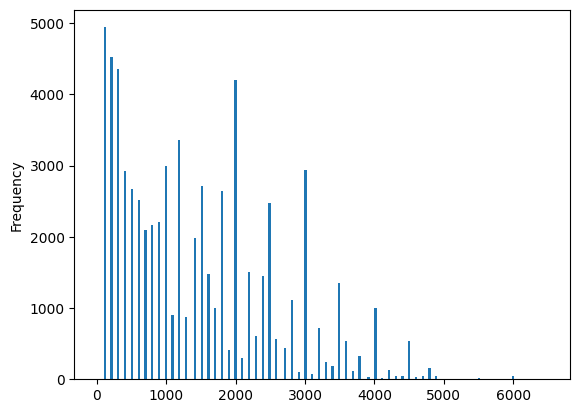

In [ ]:
num.plot.hist(bins=200);

Round 0


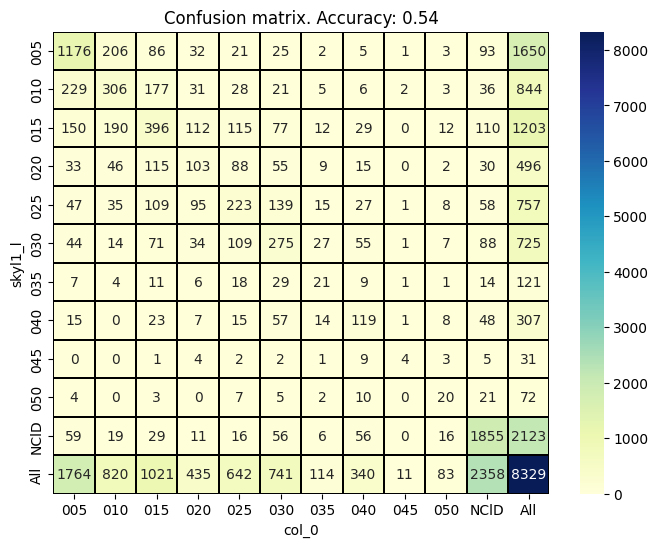

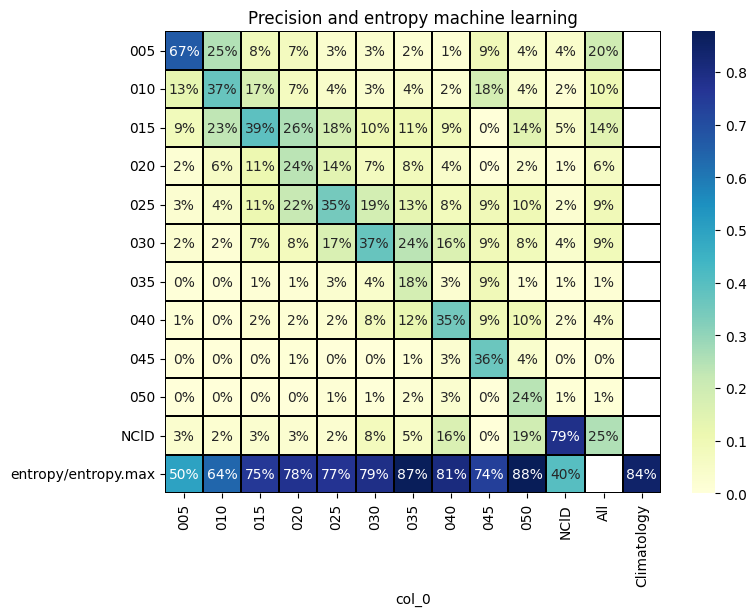

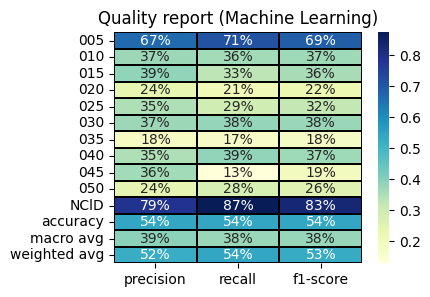

feature feature_per
102    dayofyear        3.3%
100         hour        2.0%
25          dir1        1.6%
7            rh0        1.6%
0           dir0        1.5%
39        shflx1        1.5%
41          cin1        1.5%
5          mslp0        1.5%
8    visibility0        1.4%
50          dir2        1.4%

Round 1


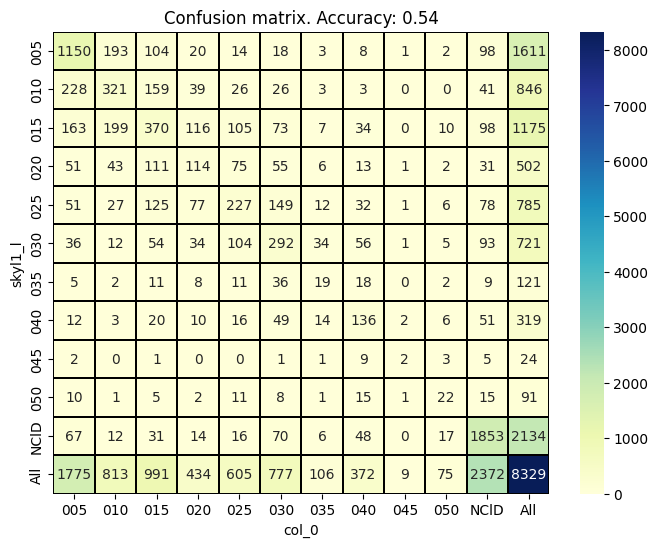

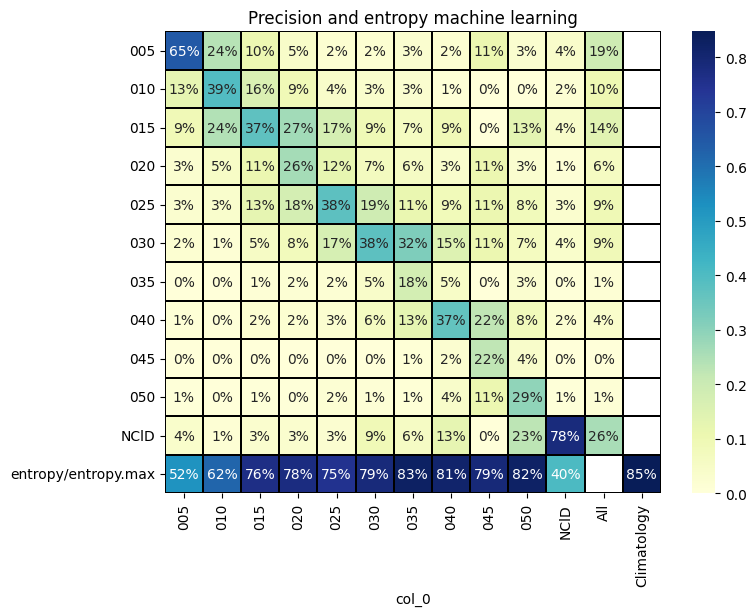

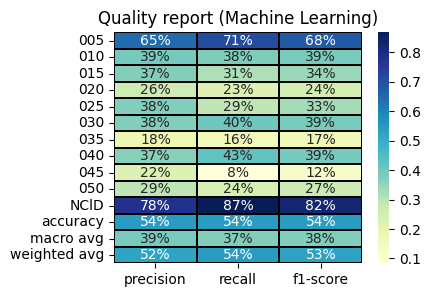

feature feature_per
102    dayofyear        3.2%
100         hour        1.9%
7            rh0        1.6%
39        shflx1        1.6%
25          dir1        1.6%
50          dir2        1.6%
5          mslp0        1.5%
8    visibility0        1.5%
41          cin1        1.5%
0           dir0        1.5%

Round 2


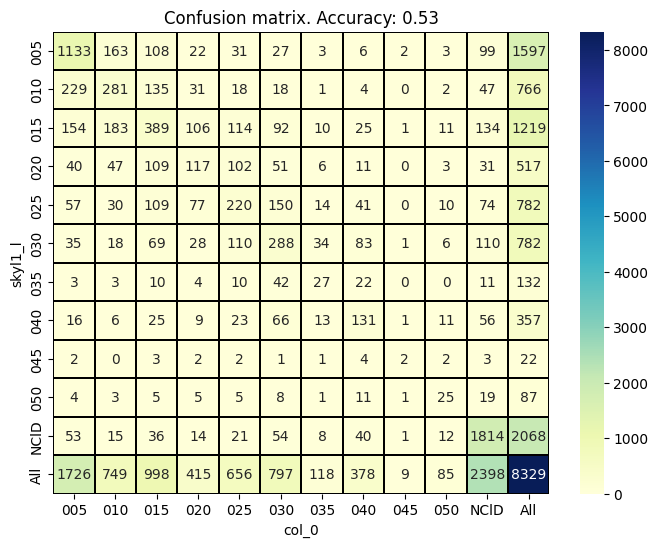

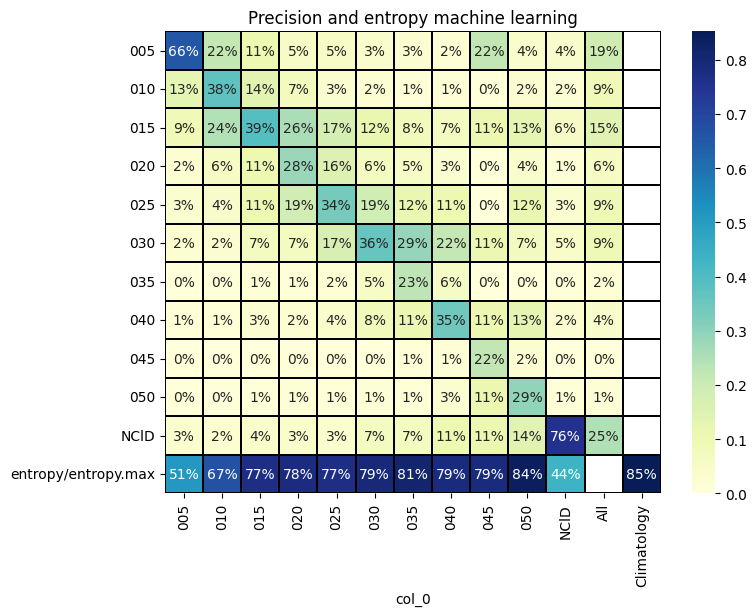

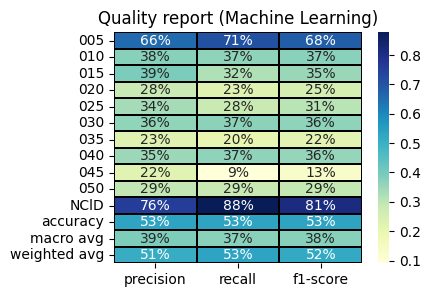

feature feature_per
102    dayofyear        3.4%
100         hour        2.0%
50          dir2        1.6%
7            rh0        1.6%
8    visibility0        1.6%
0           dir0        1.5%
75          dir3        1.5%
55         mslp2        1.5%
66          cin2        1.5%
25          dir1        1.5%

Round 3


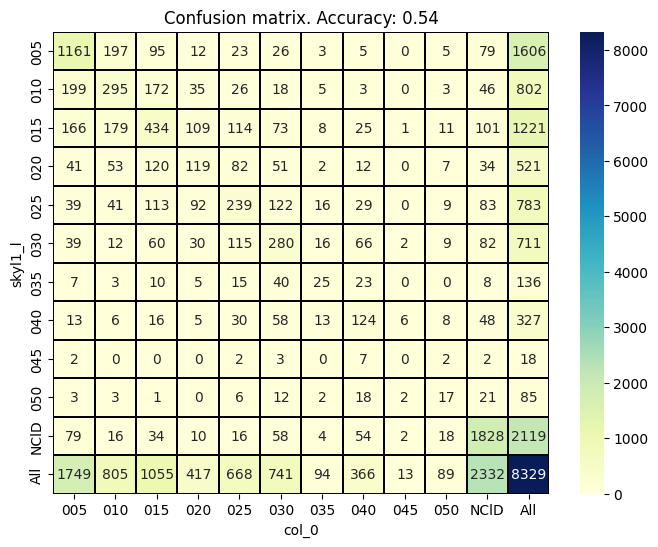

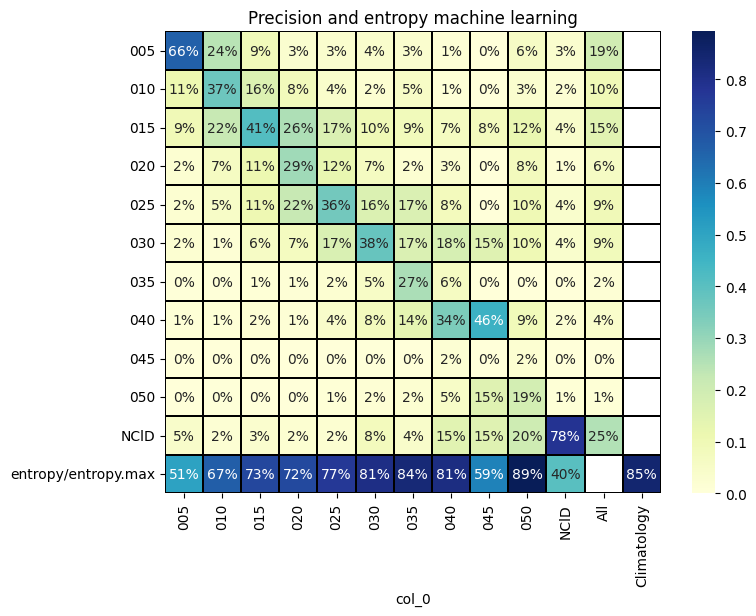

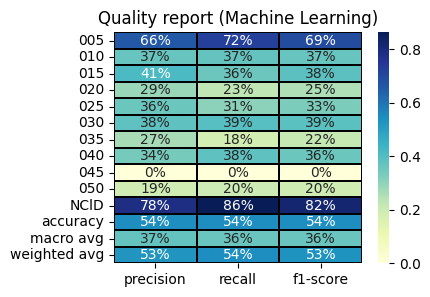

feature feature_per
102    dayofyear        3.2%
100         hour        1.9%
25          dir1        1.6%
50          dir2        1.6%
0           dir0        1.5%
39        shflx1        1.5%
8    visibility0        1.5%
7            rh0        1.5%
64        shflx2        1.5%
41          cin1        1.5%


Accuracy stadistics
       Accuracy
count    4.0000
mean     0.5375
std      0.0050
min      0.5300
25%      0.5375
50%      0.5400
75%      0.5400
max      0.5400
Shapiro test normality
p value: 0.001240724348463118
Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples
chi2_contingency last round
p-value: 5.05503758494682e-84
Significance level: 0.01
Degres of of freedom:  1
Stadistic 377.20388899945965
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 9.54 minutes


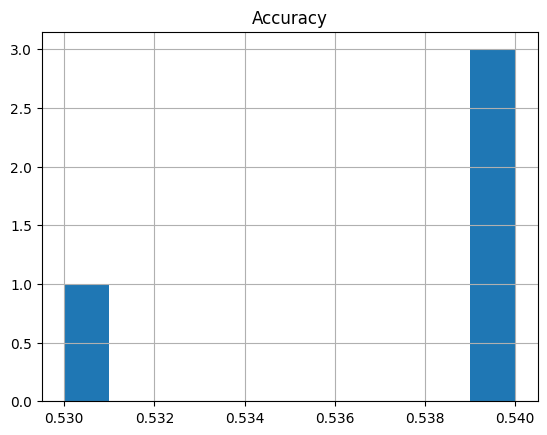

In [6]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
import math
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]


# loop random
acc_ml = []
for t in range (0,4):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [7]:
#@title Save last algorithm


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEST/algorithms/llmskyl1_LEST_d0.al", 'wb'))

Round 0


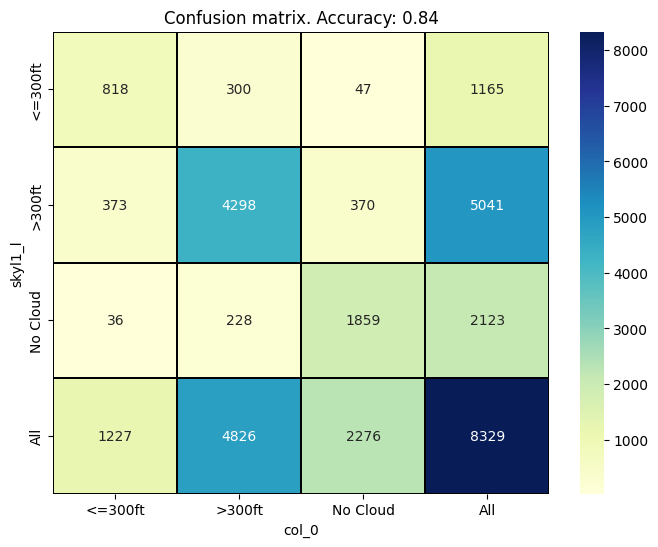

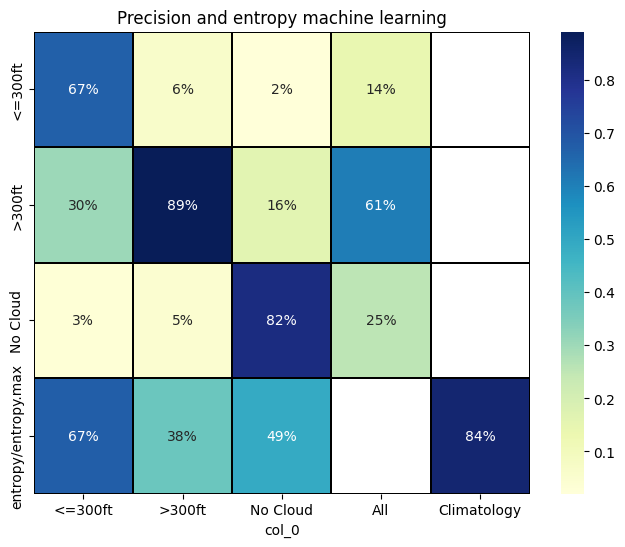

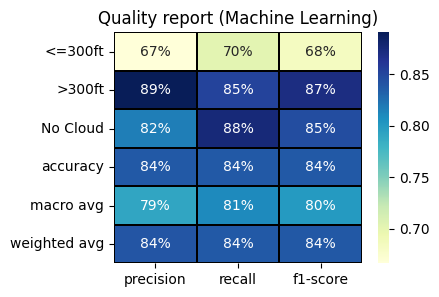

feature feature_per
93         cfl3        3.7%
18         cfl0        3.6%
43         cfl1        3.2%
68         cfl2        2.8%
32          rh1        2.3%
7           rh0        2.1%
57          rh2        2.1%
8   visibility0        2.0%
45         cft1        1.8%
82          rh3        1.8%

Round 1


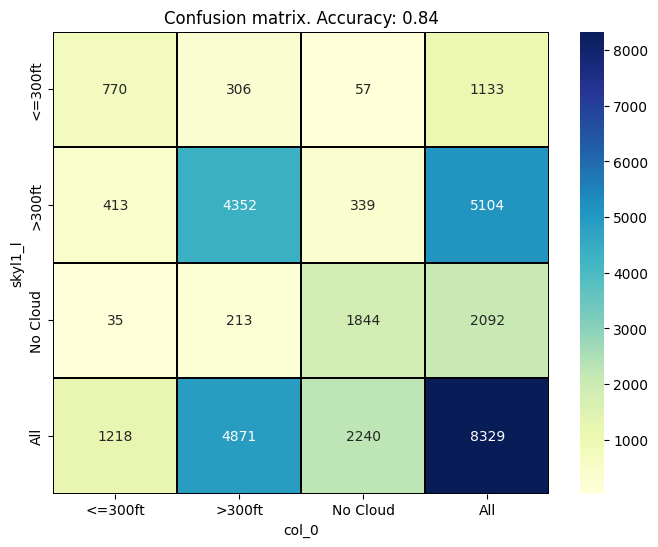

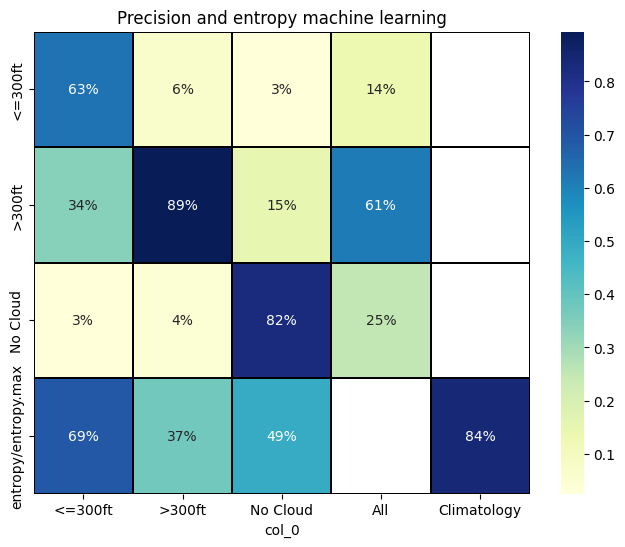

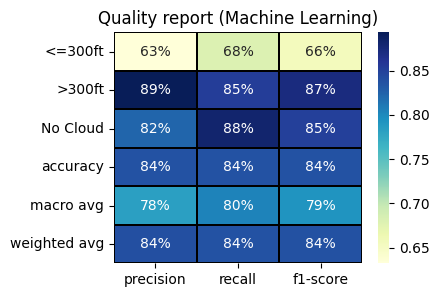

feature feature_per
93    cfl3        3.3%
43    cfl1        3.2%
68    cfl2        3.1%
18    cfl0        2.8%
82     rh3        2.2%
32     rh1        2.0%
95    cft3        2.0%
45    cft1        2.0%
20    cft0        1.9%
75    dir3        1.9%

Round 2


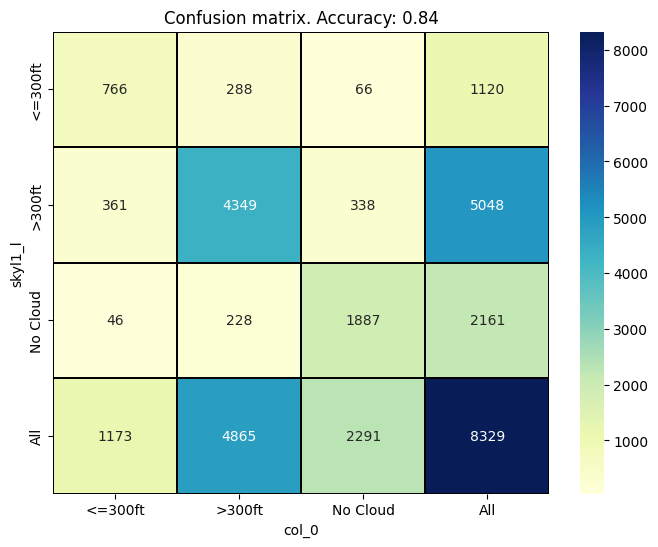

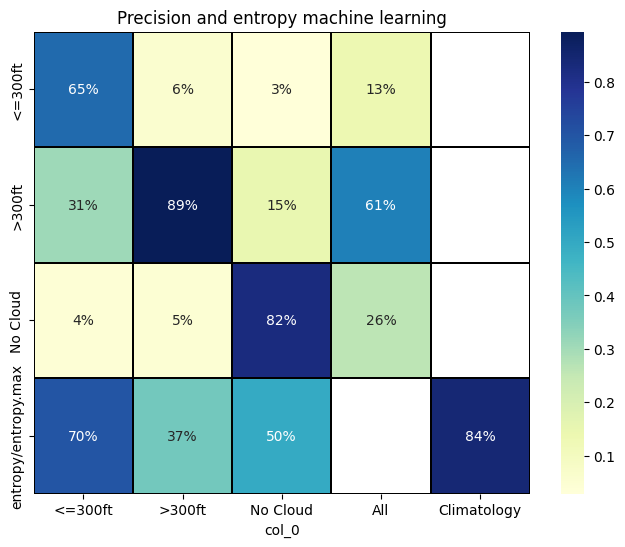

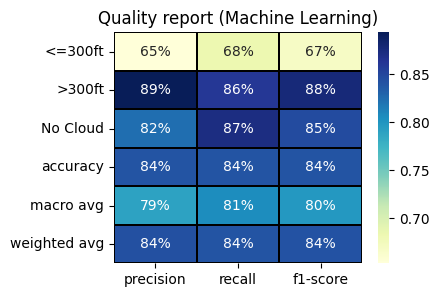

feature feature_per
68    cfl2        3.8%
93    cfl3        3.2%
43    cfl1        2.8%
18    cfl0        2.3%
95    cft3        2.1%
82     rh3        2.1%
7      rh0        2.1%
70    cft2        2.0%
25    dir1        1.9%
32     rh1        1.9%

Round 3


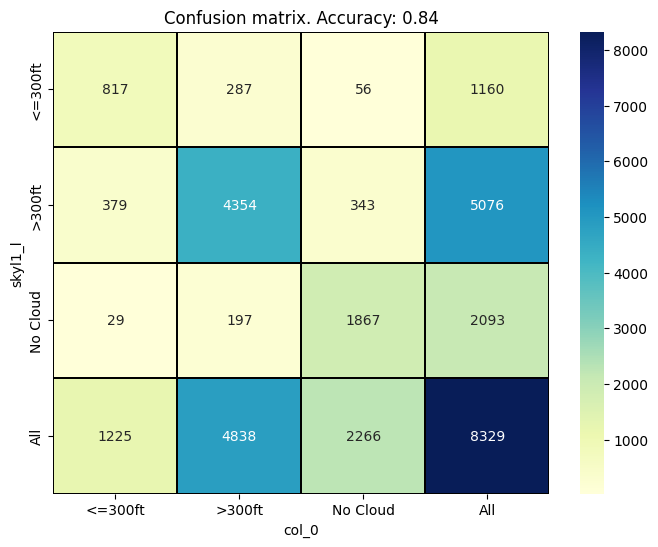

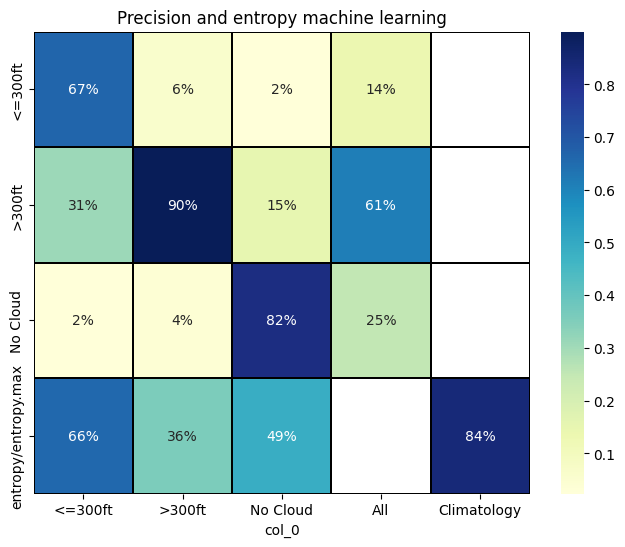

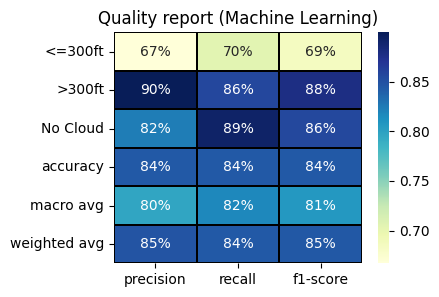

feature feature_per
68         cfl2        4.6%
18         cfl0        3.7%
43         cfl1        2.8%
57          rh2        2.1%
7           rh0        2.1%
70         cft2        2.0%
8   visibility0        2.0%
82          rh3        2.0%
0          dir0        2.0%
93         cfl3        1.9%

Round 4


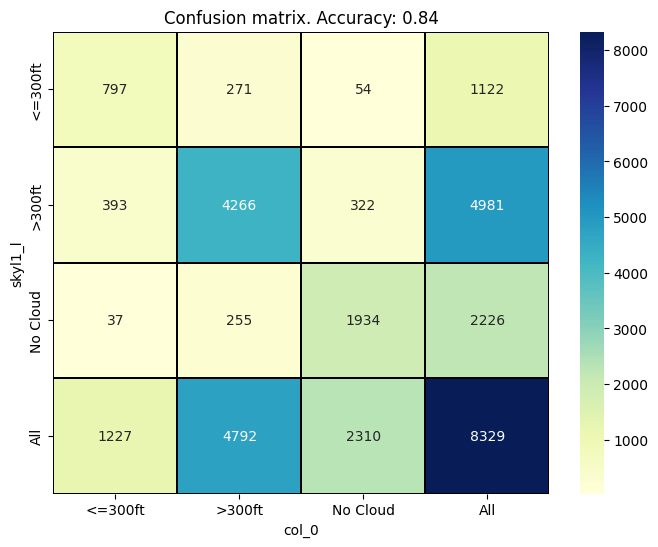

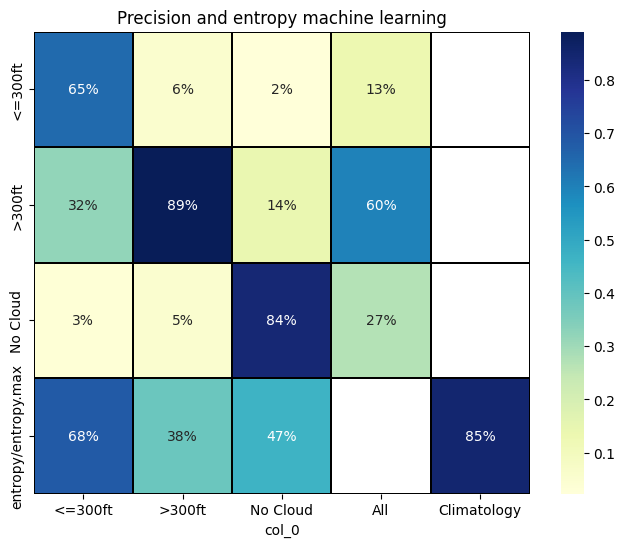

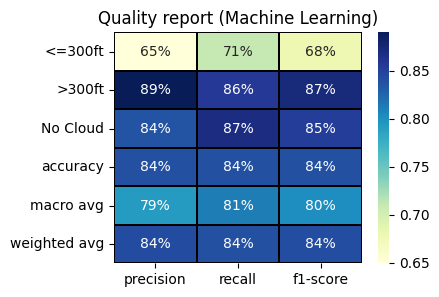

feature feature_per
93    cfl3        3.3%
43    cfl1        2.9%
95    cft3        2.7%
82     rh3        2.5%
7      rh0        2.2%
68    cfl2        2.2%
18    cfl0        2.1%
45    cft1        2.0%
57     rh2        2.0%
25    dir1        1.9%

Round 5


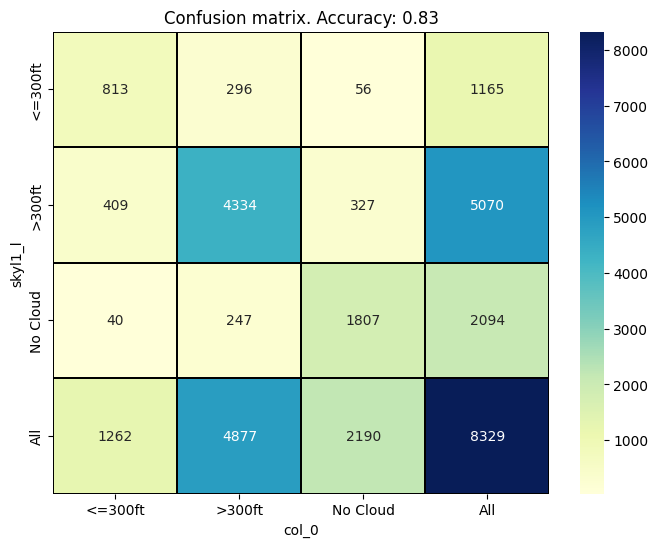

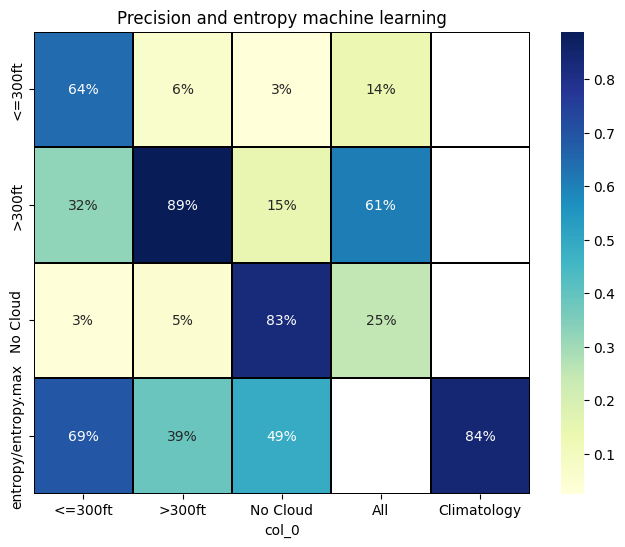

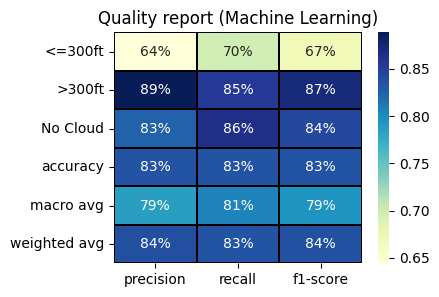

feature feature_per
93         cfl3        4.2%
68         cfl2        3.5%
43         cfl1        3.5%
18         cfl0        2.1%
57          rh2        2.0%
82          rh3        2.0%
20         cft0        2.0%
8   visibility0        1.9%
0          dir0        1.9%
70         cft2        1.9%

Round 6


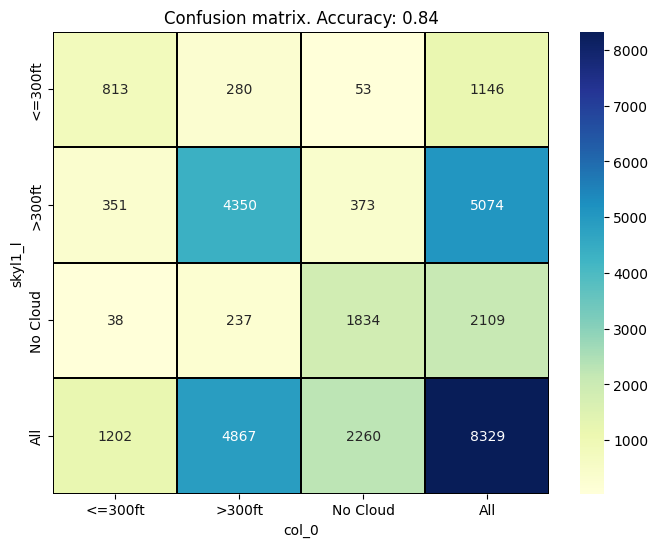

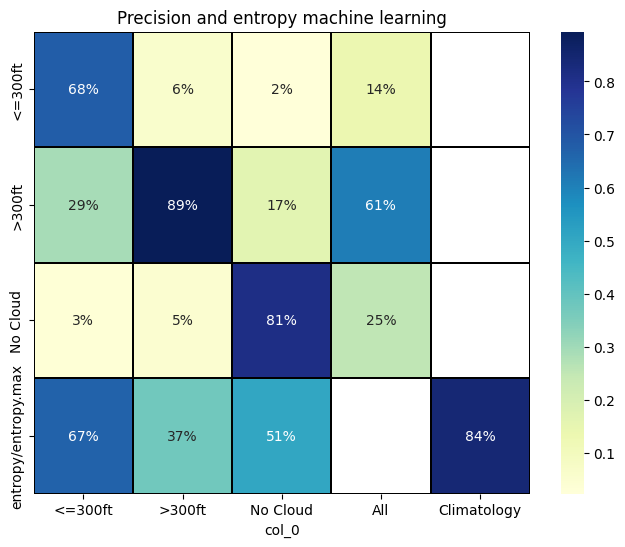

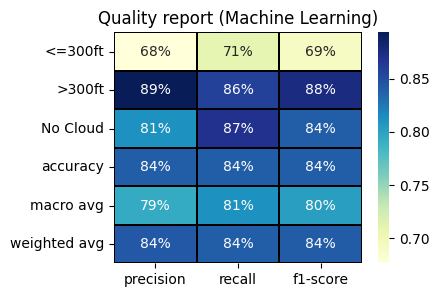

feature feature_per
68    cfl2        3.1%
43    cfl1        2.9%
18    cfl0        2.8%
95    cft3        2.4%
93    cfl3        2.4%
7      rh0        2.4%
50    dir2        2.2%
45    cft1        2.0%
82     rh3        2.0%
20    cft0        1.9%

Round 7


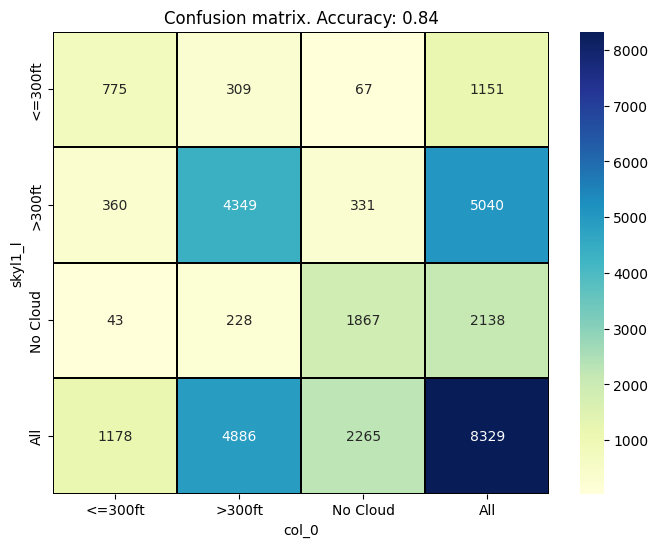

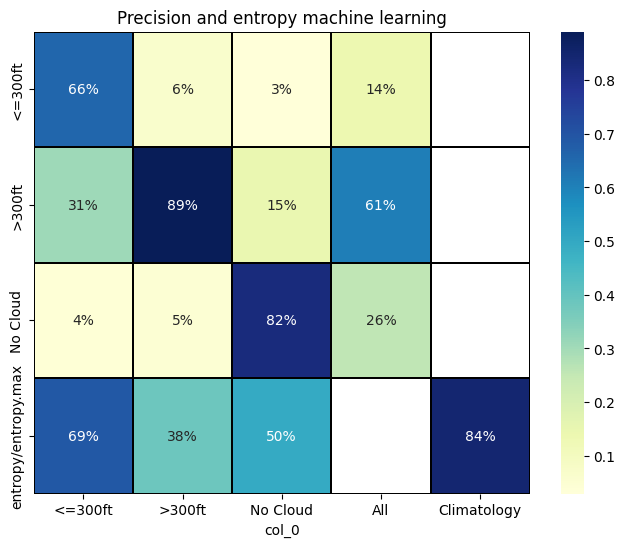

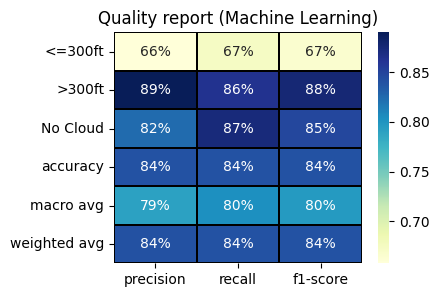

feature feature_per
93    cfl3        3.4%
43    cfl1        3.1%
18    cfl0        2.6%
45    cft1        2.5%
68    cfl2        2.2%
75    dir3        2.2%
95    cft3        2.1%
0     dir0        2.0%
57     rh2        1.9%
32     rh1        1.9%

Round 8


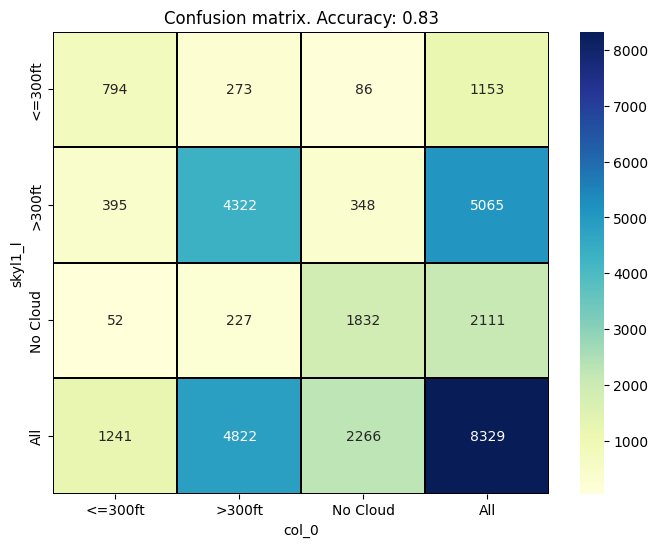

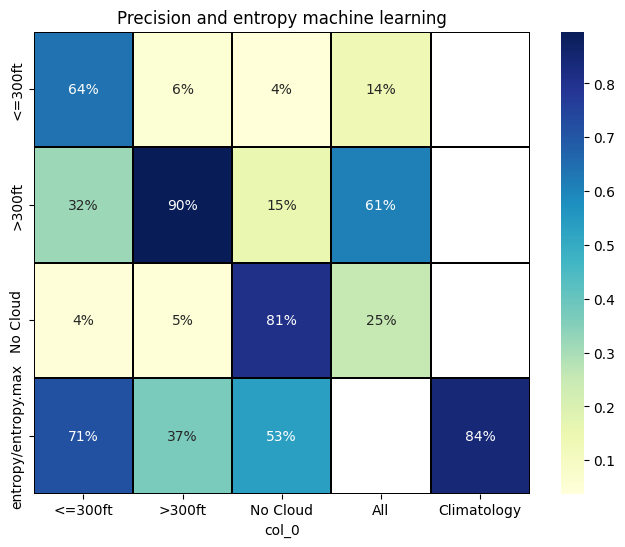

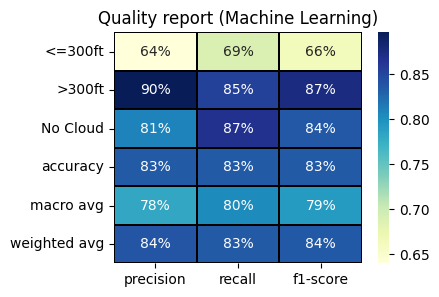

feature feature_per
68         cfl2        2.8%
18         cfl0        2.7%
93         cfl3        2.7%
43         cfl1        2.6%
45         cft1        2.6%
7           rh0        2.5%
95         cft3        2.4%
70         cft2        2.4%
0          dir0        2.0%
8   visibility0        1.9%

Round 9


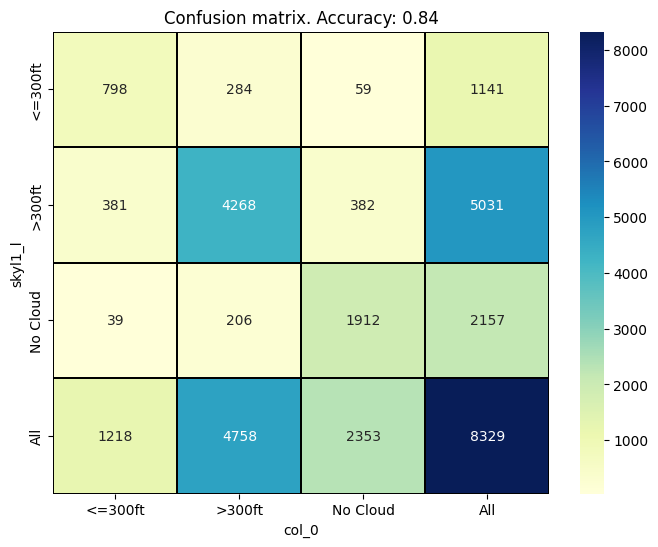

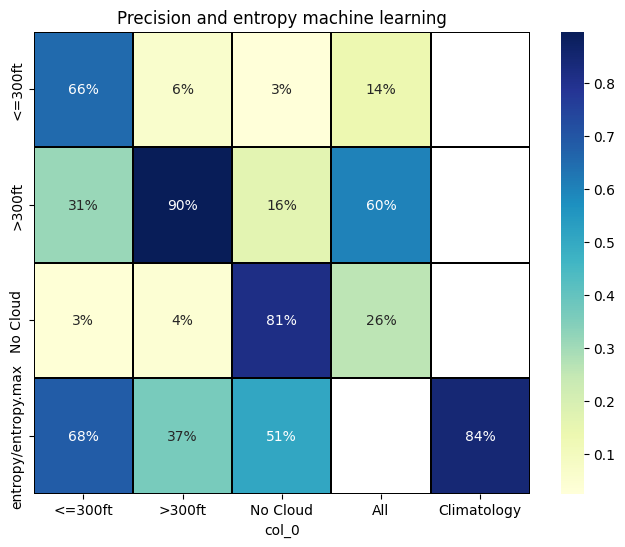

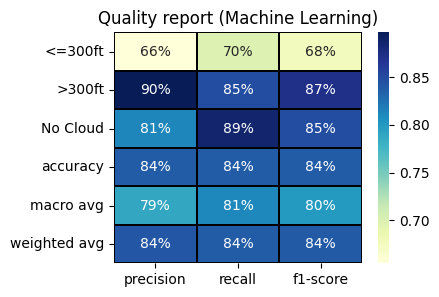

feature feature_per
43    cfl1        3.5%
93    cfl3        2.8%
68    cfl2        2.6%
95    cft3        2.4%
7      rh0        2.2%
70    cft2        2.1%
18    cfl0        2.1%
57     rh2        2.1%
75    dir3        2.0%
82     rh3        2.0%


Accuracy stadistics
        Accuracy
count  10.000000
mean    0.838000
std     0.004216
min     0.830000
25%     0.840000
50%     0.840000
75%     0.840000
max     0.840000
Shapiro test normality
p value: 4.6723621380806435e-06
Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2304.5397724461873
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 4.93 minutes


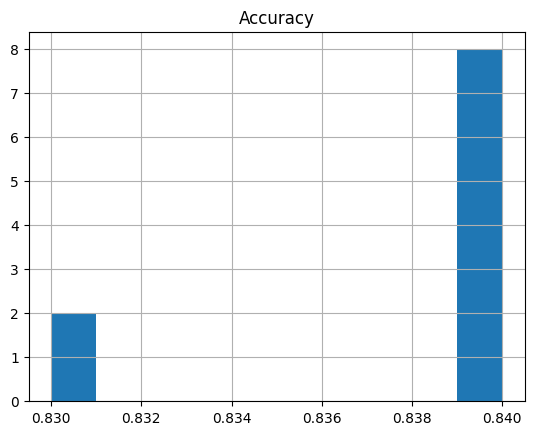

In [ ]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro
import math
from scipy.stats import entropy
from sklearn.metrics import accuracy_score

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]




# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")








In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
#pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/skyl1_LEST_d0.al", 'wb'))

Round 0


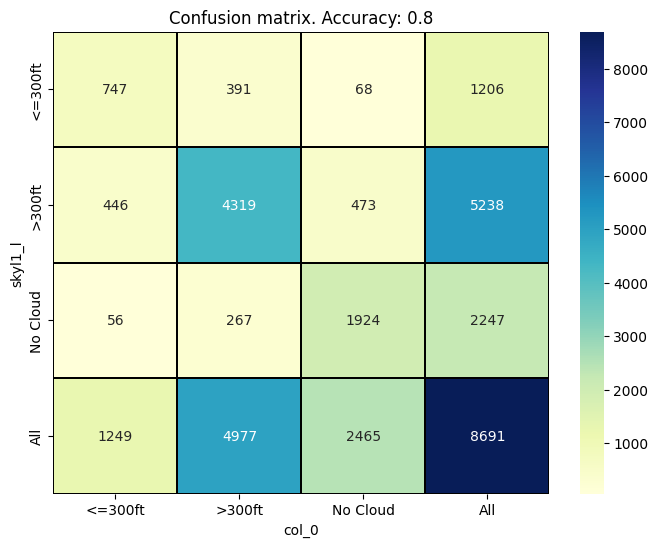

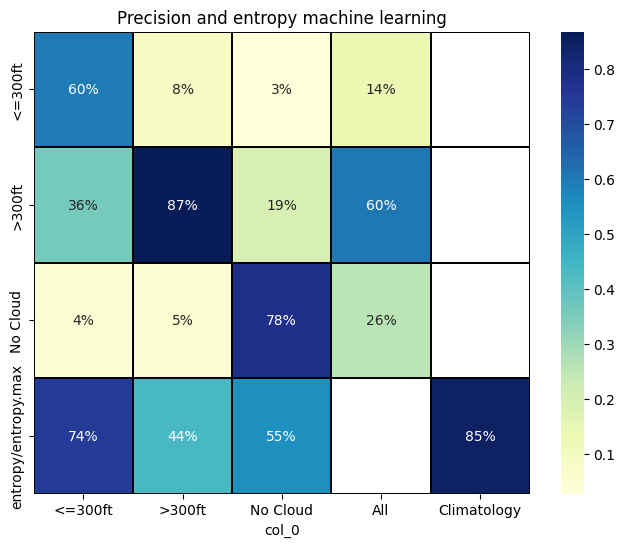

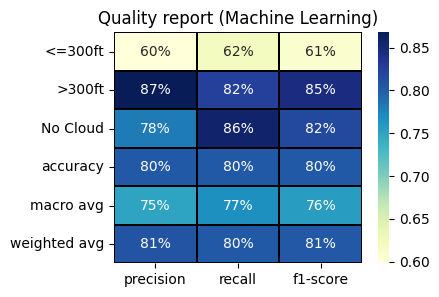

feature feature_per
102   dayofyear        4.4%
100        hour        2.8%
7           rh0        2.1%
39       shflx1        1.9%
25         dir1        1.7%
75         dir3        1.7%
64       shflx2        1.6%
50         dir2        1.5%
103  weekofyear        1.5%
49        T8501        1.5%

Round 1


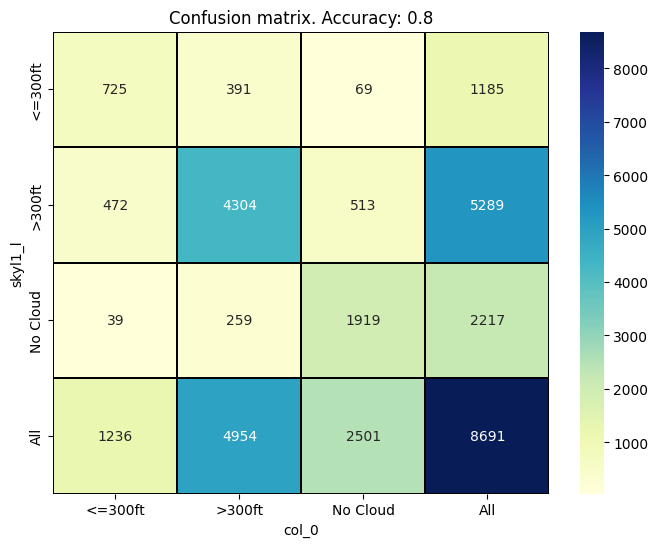

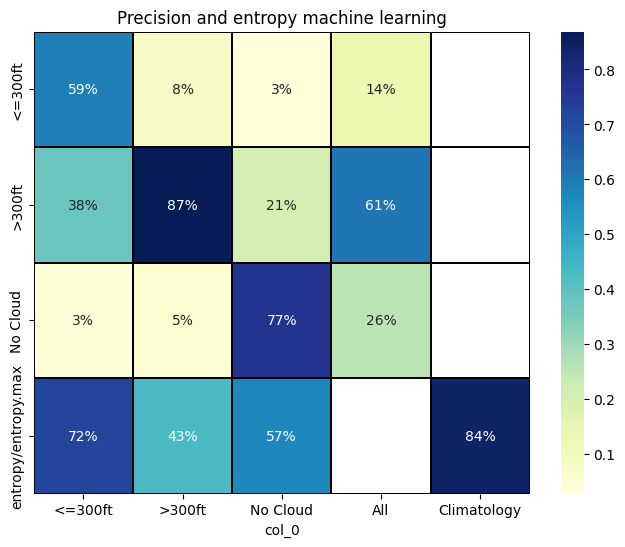

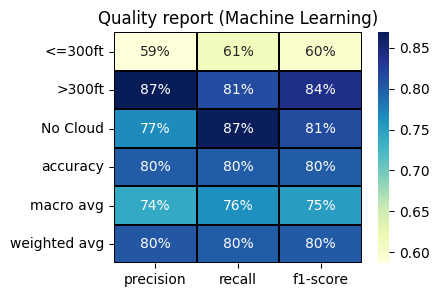

feature feature_per
102  dayofyear        4.5%
100       hour        2.4%
7          rh0        2.1%
39      shflx1        2.0%
0         dir0        1.6%
25        dir1        1.6%
101      month        1.6%
60      lwflx2        1.5%
75        dir3        1.5%
64      shflx2        1.5%

Round 2


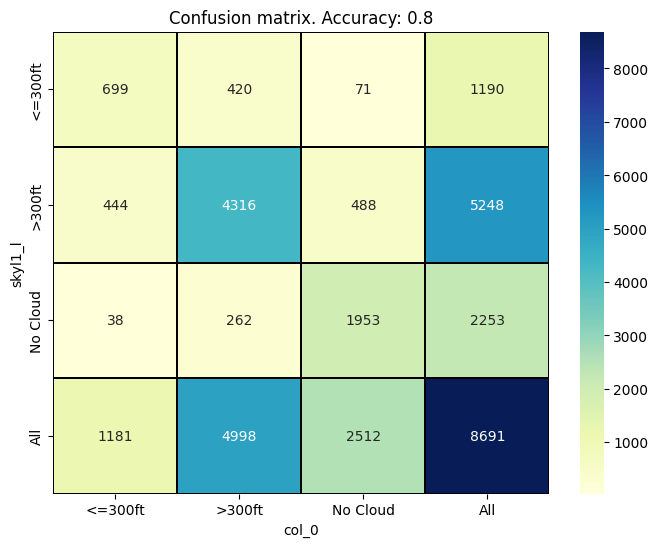

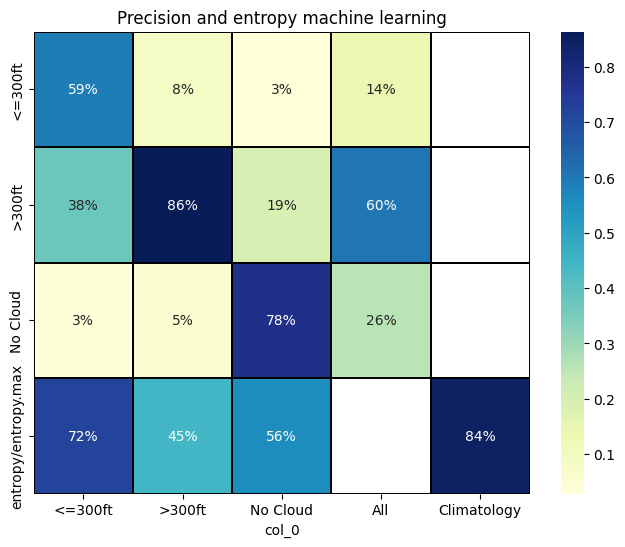

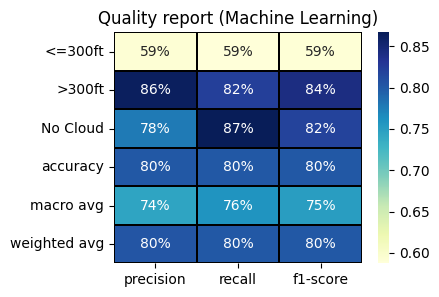

feature feature_per
102   dayofyear        4.0%
100        hour        2.5%
7           rh0        2.1%
75         dir3        1.8%
39       shflx1        1.7%
0          dir0        1.6%
25         dir1        1.5%
103  weekofyear        1.5%
60       lwflx2        1.5%
49        T8501        1.5%

Round 3


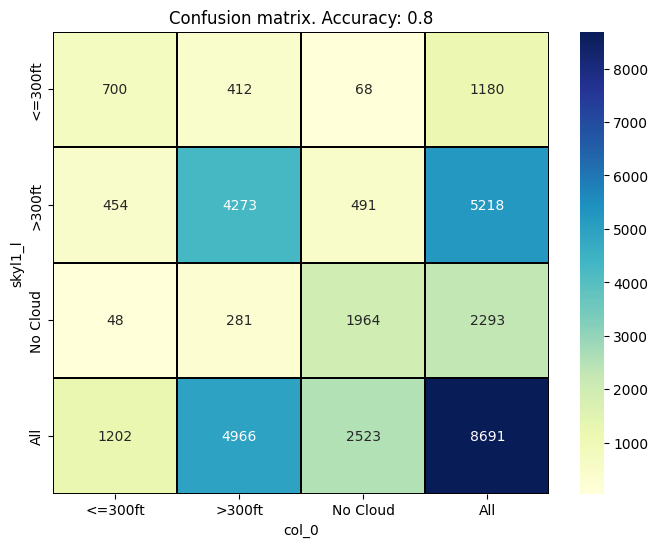

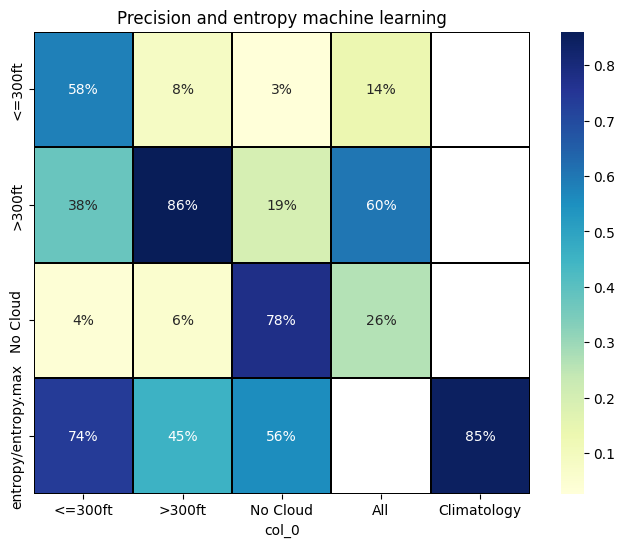

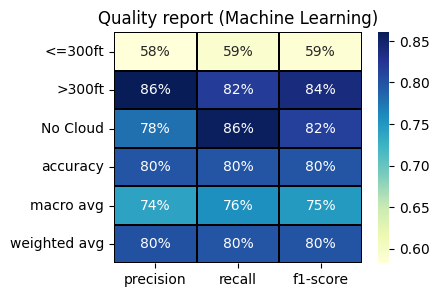

feature feature_per
102    dayofyear        4.6%
100         hour        2.6%
7            rh0        2.1%
39        shflx1        1.8%
75          dir3        1.7%
64        shflx2        1.6%
89        shflx3        1.6%
103   weekofyear        1.5%
60        lwflx2        1.5%
33   visibility1        1.5%

Round 4


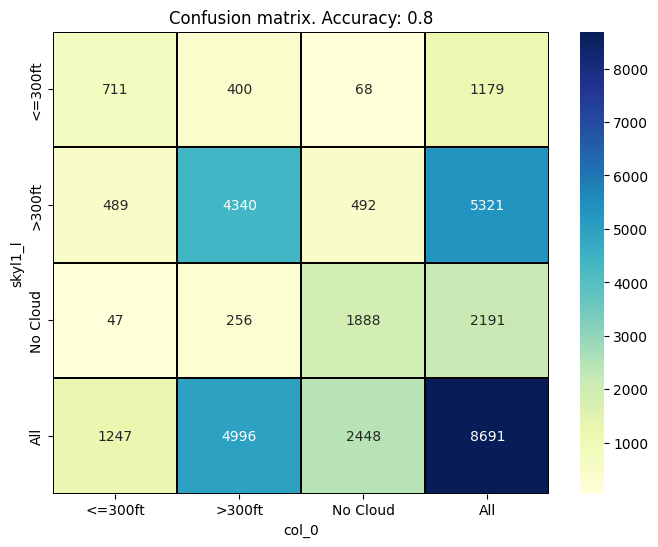

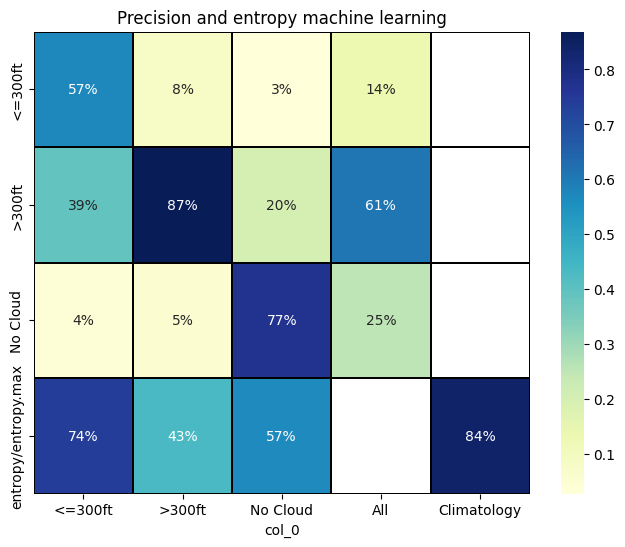

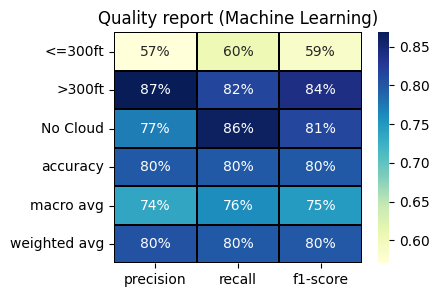

feature feature_per
102   dayofyear        4.4%
100        hour        2.4%
7           rh0        2.2%
39       shflx1        1.9%
25         dir1        1.7%
75         dir3        1.7%
64       shflx2        1.6%
54   wind_gust2        1.6%
101       month        1.5%
103  weekofyear        1.5%

Round 5


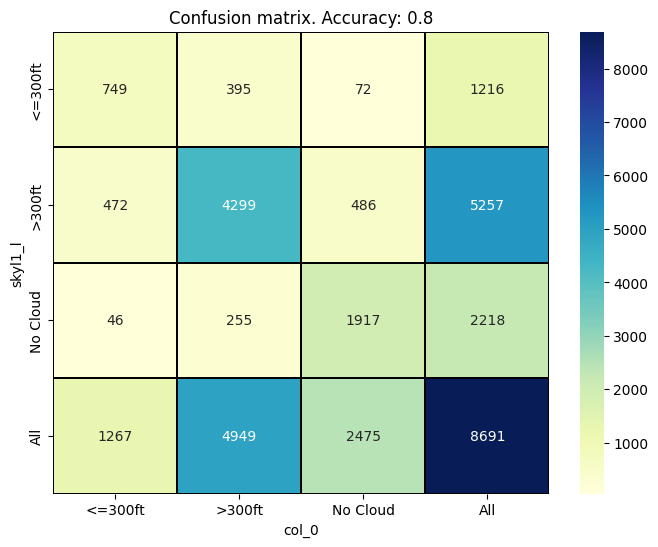

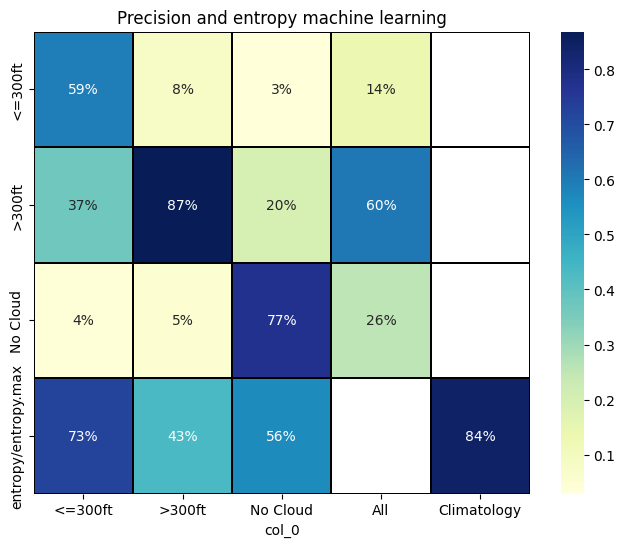

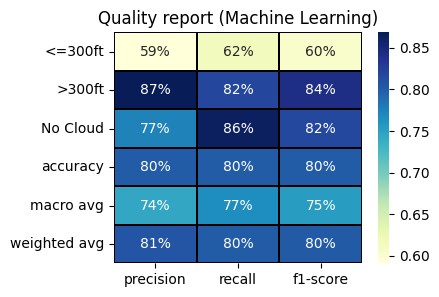

feature feature_per
102  dayofyear        4.4%
100       hour        2.8%
7          rh0        2.0%
39      shflx1        1.9%
75        dir3        1.5%
50        dir2        1.5%
60      lwflx2        1.5%
101      month        1.4%
89      shflx3        1.4%
64      shflx2        1.4%

Round 6


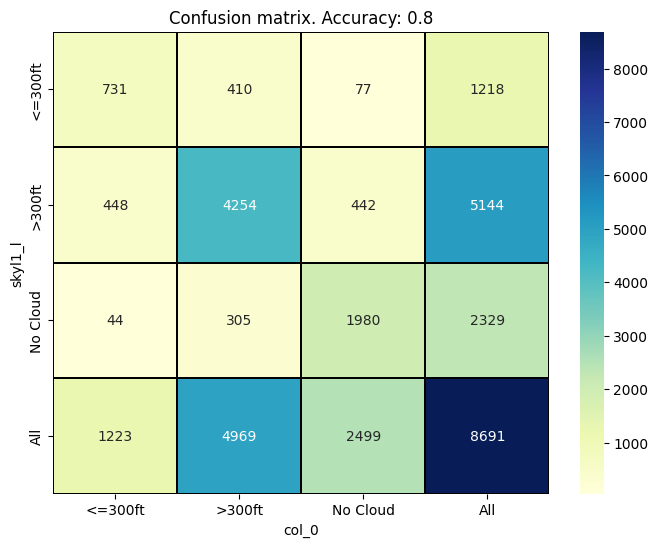

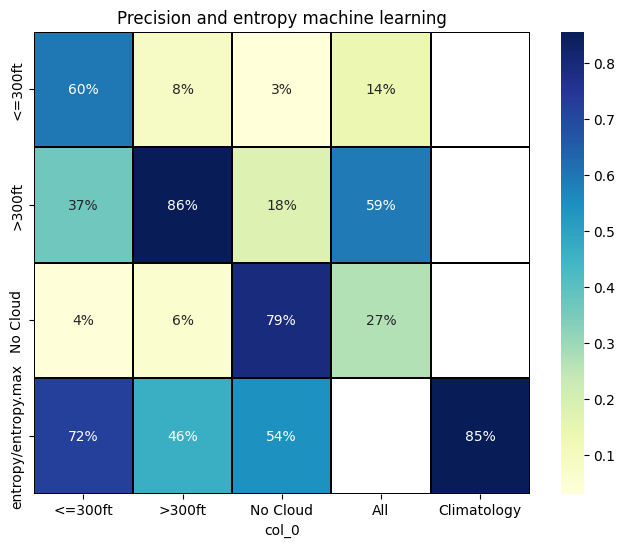

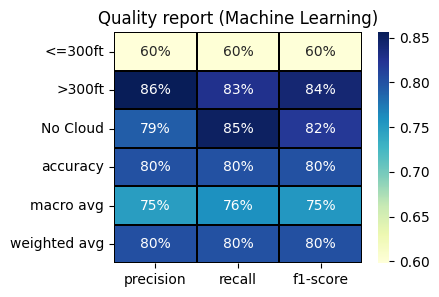

feature feature_per
102    dayofyear        4.1%
100         hour        2.6%
7            rh0        2.1%
39        shflx1        1.7%
25          dir1        1.6%
64        shflx2        1.5%
54    wind_gust2        1.5%
75          dir3        1.5%
50          dir2        1.5%
33   visibility1        1.5%

Round 7


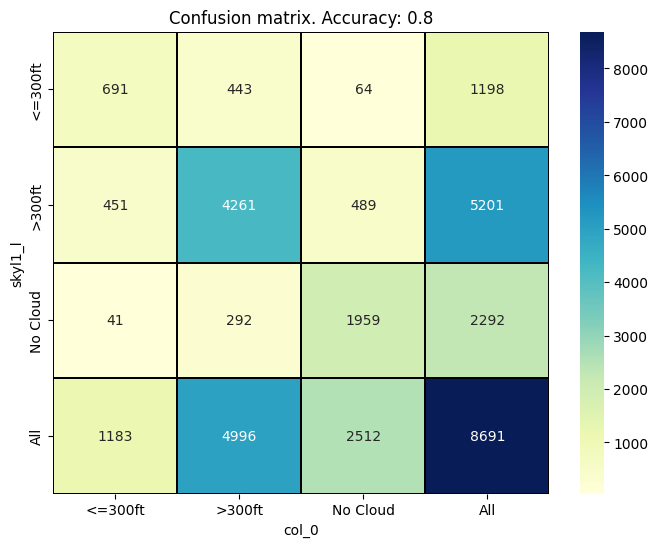

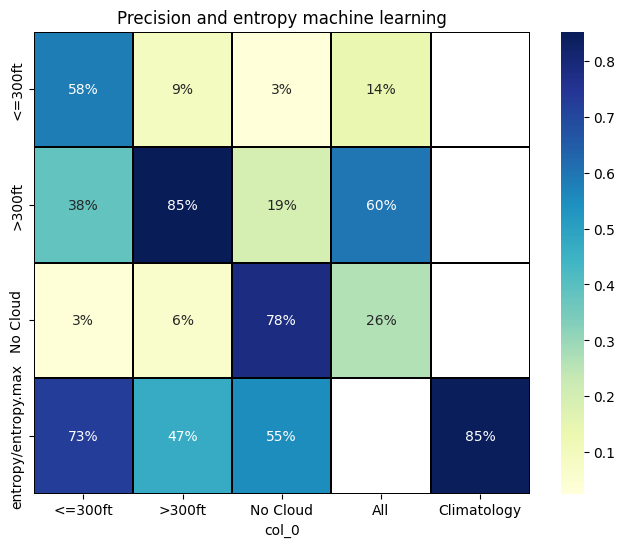

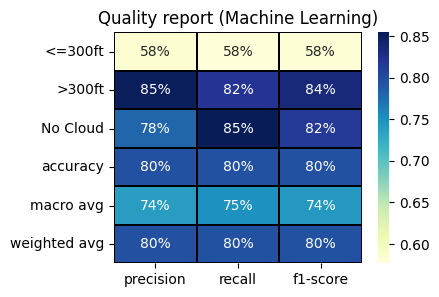

feature feature_per
102   dayofyear        4.3%
100        hour        2.6%
7           rh0        2.2%
39       shflx1        2.0%
25         dir1        1.6%
50         dir2        1.6%
64       shflx2        1.6%
54   wind_gust2        1.6%
75         dir3        1.6%
0          dir0        1.5%

Round 8


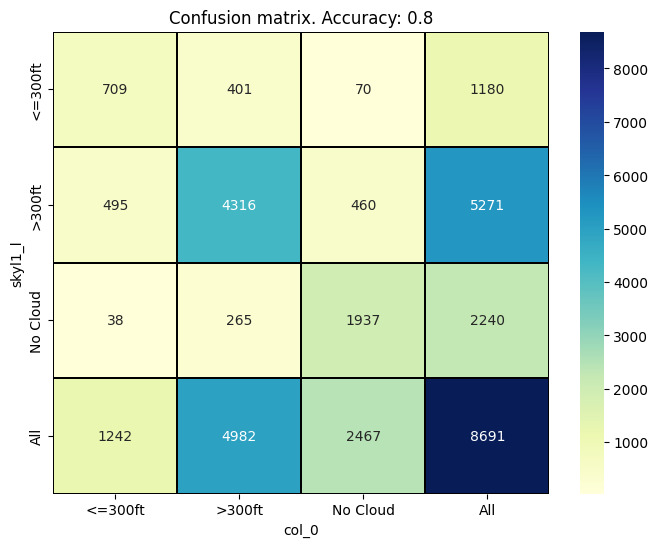

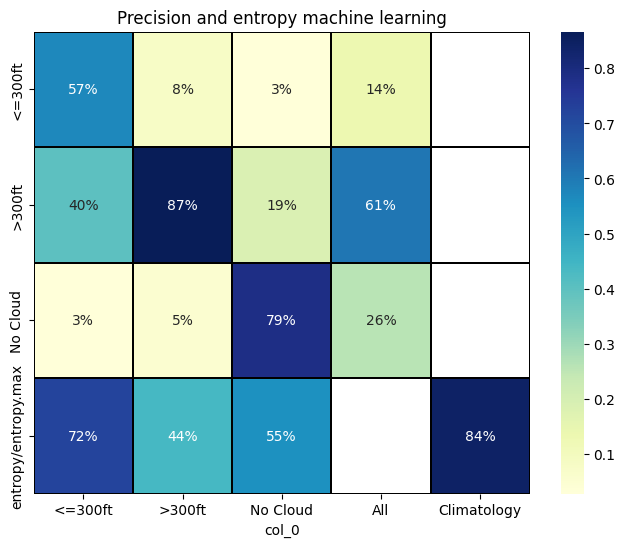

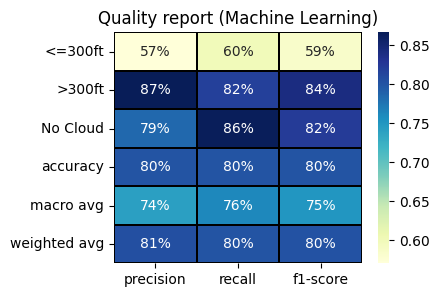

feature feature_per
102   dayofyear        4.1%
100        hour        2.5%
7           rh0        2.1%
39       shflx1        1.7%
75         dir3        1.6%
25         dir1        1.6%
64       shflx2        1.6%
60       lwflx2        1.6%
103  weekofyear        1.5%
74        T8502        1.4%

Round 9


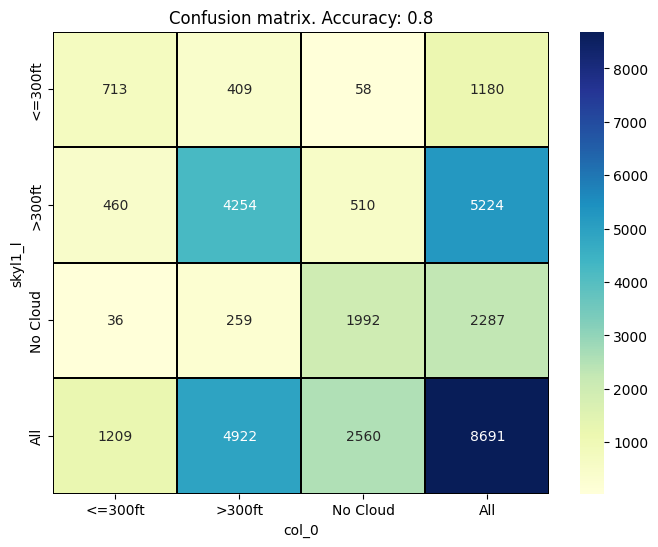

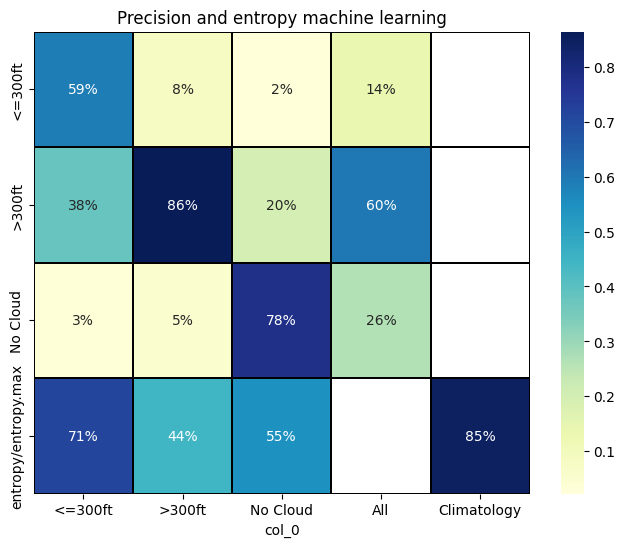

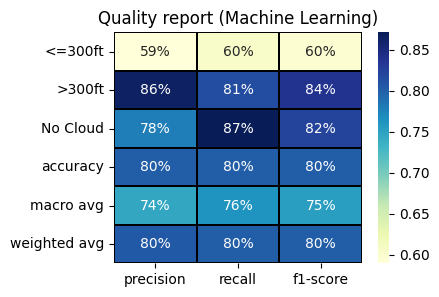

feature feature_per
102  dayofyear        4.5%
100       hour        2.4%
39      shflx1        2.2%
7          rh0        2.0%
25        dir1        1.7%
74       T8502        1.6%
64      shflx2        1.5%
60      lwflx2        1.5%
0         dir0        1.5%
75        dir3        1.5%


Accuracy stadistics
       Accuracy
count      10.0
mean        0.8
std         0.0
min         0.8
25%         0.8
50%         0.8
75%         0.8
max         0.8
Shapiro test normality
p value: 1.0
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1629.4123930583507
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 5.42 minutes


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1813: UserWarning:

Input data for shapiro has range zero. The results may not be accurate.



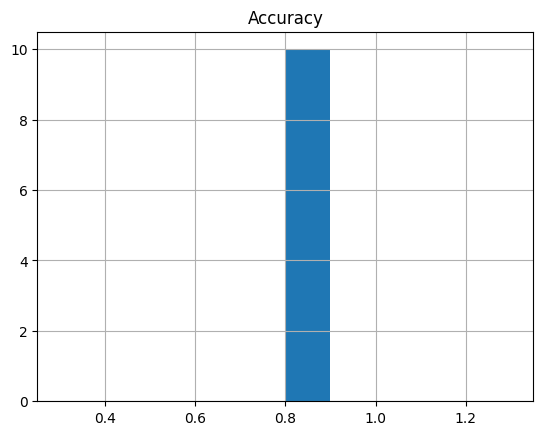

In [ ]:
#@title Load meteorological model forecast D1. ML LGBMClassifier. Samples 10. Heidke Skill score.
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LEST/input_files/lat42.896lon-8.415p4R4KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).drop(columns=["skyl1_o"]).dropna()


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.skyl1_l
X = df_all.iloc[:,1:]


# loop random
acc_ml = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  y_pred = ml_model.predict(X_test)
  acc_ml.append(round(accuracy_score(y_test, y_pred),2))
  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)

  plt.figure(figsize=(8, 6))
  plt.title("Confusion matrix. Accuracy: {}".format(round(acc_ml[t],2)))
  seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
  plt.show()

  #Precision and entropy
  plt.figure(figsize=(8, 6))
  plt.title("Precision and entropy machine learning")

  column_sc = pd.crosstab(y_test, ml_model.predict(X_test), margins=True,normalize="columns")
  entropy_values = pd.DataFrame(
    entropy(column_sc, base=2) / (math.log2(column_sc.shape[0])),
    columns=["entropy/entropy.max"],
    index=column_sc.columns).T
  column_sc = pd.concat([column_sc, entropy_values.rename(columns={"All": "Climatology"})])
  seab = sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #quality report
  plt.figure(figsize=(4, 3))
  plt.title("Quality report (Machine Learning)")
  qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
  seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
  plt.show()

  #feature importance
  def format_as_percentage(value):
      return '{:.1%}'.format(value)
  fea_imp =pd.DataFrame({"feature":X.columns,
                      "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
  fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
  fea_sort = fea_imp.sort_values(by="importance",ascending=False)
  display(fea_sort[["feature","feature_per"]][:10])



print("\nAccuracy stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(acc_ml,columns=["Accuracy"]).describe())

#sample less 5000
sta, p = shapiro(acc_ml)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(acc_ml,columns=["Accuracy"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")


In [ ]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"acc_ml":acc_ml[-1]}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/LEST/algorithms/skyl1_LEST_d1.al", 'wb'))